In [1]:
from tqdm import tqdm 
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import medmnist 
from medmnist import INFO, Evaluator

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

from sklearn.metrics import roc_auc_score

C:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(f'MEDMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}')

MEDMNIST v2.1.0 @ https://github.com/MedMNIST/MedMNIST/


In [3]:
data_flag = 'pneumoniamnist'
#data_flag = 'organamnist'
#data_flag = 'breastmnist'
download = 'True'

epochs = 20
BATCH_SIZE = 32
lr = 0.001
num_workers = 4 # number of parallel processes for data preparation

info = INFO[data_flag]
task = info['task'] # multiclass
n_channels = info['n_channels'] # 3 channels
n_classes = len(info['label']) # 9 classes
class_names = info['label']
DataClass = getattr(medmnist, info['python_class'])

In [4]:
print(f"The number of classes is: {n_classes}, and the number of channels is: {n_channels}.")

The number of classes is: 2, and the number of channels is: 1.


In [5]:
class_names

{'0': 'normal', '1': 'pneumonia'}

In [6]:
print(info)

{'python_class': 'PneumoniaMNIST', 'description': 'The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.', 'url': 'https://zenodo.org/record/6496656/files/pneumoniamnist.npz?download=1', 'MD5': '28209eda62fecd6e6a2d98b1501bb15f', 'task': 'binary-class', 'label': {'0': 'normal', '1': 'pneumonia'}, 'n_channels': 1, 'n_samples': {'train': 4708, 'val': 524, 'test': 624}, 'license': 'CC BY 4.0'}


In [7]:
# preprocessing
data_transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.GaussianBlur(kernel_size=(5,9),sigma = (0.1, 5)),
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[.5])
])


# Load the data
train_dataset = DataClass(split ='train', transform = data_transform, download=download)
test_dataset = DataClass(split='test', transform = data_transform, download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = num_workers)
train_loader_at_eval = data.DataLoader(dataset = train_dataset, batch_size = 2*BATCH_SIZE, shuffle = False, num_workers = num_workers)
test_loader = data.DataLoader(dataset = test_dataset, batch_size = 1, shuffle = False, num_workers = num_workers)




Using downloaded and verified file: C:\Users\Theodora\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\Theodora\.medmnist\pneumoniamnist.npz


In [8]:
print(train_dataset)
print('='*50)
print(test_dataset)

Dataset PneumoniaMNIST (pneumoniamnist)
    Number of datapoints: 4708
    Root location: C:\Users\Theodora\.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'pneumonia'}
    Number of samples: {'train': 4708, 'val': 524, 'test': 624}
    Description: The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0
Dataset PneumoniaMNIST (pneumoniamnist)
    Number of datapoints: 624
    Root location: C:\Users\Theodora\.medmnist
    Split: test
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'p

In [9]:
len(train_loader), len(test_loader), len(train_loader_at_eval)

(148, 624, 74)

In [10]:
# Visualization
train_dataset.montage(length=1)

C:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\medmnist\utils.py:25: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


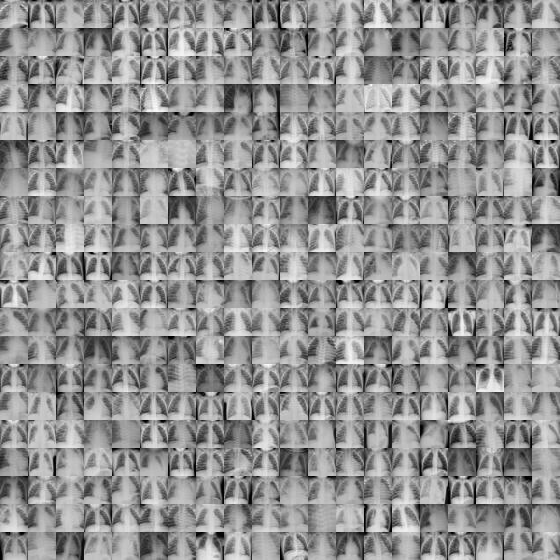

In [11]:
# montage
train_dataset.montage(length=20)

In [12]:
class ConvNet(nn.Module):
    def __init__(self, in_channels, num_classes, p):
        super(ConvNet, self).__init__()
        
        self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels, 64, kernel_size = 3, stride = 1, padding = 1), # input size = 32, conv2d = 32, conv2d = 32, maxpool2d = 16
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        #nn.BatchNorm2d(64),
        nn.MaxPool2d(kernel_size=2, stride=2), 
        )
        
        self.layer2 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding = 1),   # input size = 16, conv2d = 16, conv2d = 16, maxpooling = 8
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size = 3, stride =1, padding = 1),
        nn.ReLU(),
        #nn.BatchNorm2d
        nn.Dropout(p),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        
        self.layer3 = nn.Sequential(
        nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1), # input_size = 8, conv2d = 8, conv2d = 8, maxpool = 4
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size = 3, stride =1, padding = 1),
        nn.ReLU(),
        nn.Dropout(p),
        nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        
        self.fc = nn.Sequential(
        nn.Flatten(),
        nn.Linear(256*4*4, 240),
        nn.ReLU(),
        nn.Dropout(p),
        nn.Linear(240, num_classes)
        )
        
    def forward(self,x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.fc(x)
        return(x)
        



In [43]:
class LeNet(nn.Module):
    def __init__(self, input_channels, num_classes, p):
        super(LeNet, self).__init__()
        self.layer1 = nn.Sequential(
        nn.Conv2d(input_channels,24,5),
        nn.ReLU(),
        nn.MaxPool2d(2))

        self.layer2 = nn.Sequential(
        nn.Conv2d(24, 48, 5),
        nn.ReLU(),
        nn.Dropout(p),
        nn.MaxPool2d(2))

        self.fc = nn.Sequential(
        nn.Flatten(),
        nn.Linear(48*5*5, 240),
        nn.ReLU(),
        nn.Dropout(p),
        nn.Linear(240, num_classes))
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.fc(x)
        return x
    


In [55]:
class ConvNet2(nn.Module):
    def __init__(self, in_channels, num_classes, p):
        super(ConvNet2, self).__init__()
        self.conv_block = nn.Sequential(
        nn.Conv2d(in_channels, out_channels = 32, kernel_size=3),   # input size = 32, conv2d: 30, maxPool: 15
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2),
        nn.Conv2d(32, 64,3),    # input size = 15, conv2d:  
        nn.ReLU(),
        #nn.Dropout(p),
        nn.MaxPool2d(2,2),
        nn.Conv2d(64, 128, 3),
        nn.ReLU(),
        nn.Dropout(p),
        nn.MaxPool2d(2,2),
        nn.Conv2d(128, 256, 1),
        nn.ReLU(),
        nn.Dropout(p),
        nn.MaxPool2d(2,2))
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features = 256, out_features = 128),
            nn.Dropout2d(p=0.4),
            nn.Linear(in_features = 128, out_features = num_classes))
        
    def forward(self, x):
        x= self.conv_block(x)
        #print(x.shape)
        bs, _, _, _ = x.shape
        x = F.adaptive_avg_pool2d(x,1).reshape(bs, -1)
        x = self.classifier(x)
        return x
        


In [13]:
def train(model, trainloader, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0.0
    counter = 0
    for i, (image, labels) in tqdm(enumerate(trainloader), total = len(trainloader)):
        counter += 1
        #image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(image)
        
        # Calculate the loss
        if task == 'multi-label, binary-class':
            labels = labels.to(torch.float32)
            loss = criterion(outputs, labels)
        else:
            labels = labels.squeeze().long()
            loss = criterion(outputs, labels)
            
        train_running_loss += loss.item()
        # Calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds==labels).sum().item()
        # Backpropagation
        loss.backward()
        #Update teh weights
        optimizer.step()
        
    # Loss and accuracy for the complete epoch
    epoch_loss = train_running_loss/counter
    epoch_acc = 100.*(train_running_correct/ len(trainloader.dataset))
    return epoch_loss, epoch_acc


In [14]:
len(train_loader.dataset)

4708

In [16]:
if __name__ == '__main__':
    # Criterion
    if task == 'multi-label, binary-class':
        criterion = nn.BCEWithLogitsLoss()
    else:
        criterion = nn.CrossEntropyLoss()
    
        
    # model selection
    model = ConvNet(n_channels, n_classes, p=0.5)
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    # Loss function
    optimizer = optim.SGD(model.parameters(), lr, momentum = 0.9)
    
    # Lists to keep track of losses and accuracies
    train_loss = []
    train_acc = []
    # Starting the training
    for epoch in range(epochs):
        print(f"[INFO]: Epoch {epoch+1} of {epochs}")
        train_epoch_loss, train_epoch_acc = train(model, train_loader, 
                                                optimizer, criterion)
        train_loss.append(train_epoch_loss)
        train_acc.append(train_epoch_acc)
        
        print(f"Training Loss: {train_epoch_loss:.3f}, training_acc: {train_epoch_acc:.3f}")
        print ('='*50)


[INFO]: Epoch 1 of 20
Training


100%|██████████| 148/148 [00:06<00:00, 21.66it/s]


Training Loss: 0.606, training_acc: 74.214
[INFO]: Epoch 2 of 20
Training


100%|██████████| 148/148 [00:02<00:00, 59.00it/s]


Training Loss: 0.566, training_acc: 74.214
[INFO]: Epoch 3 of 20
Training


100%|██████████| 148/148 [00:02<00:00, 63.72it/s]


Training Loss: 0.557, training_acc: 74.214
[INFO]: Epoch 4 of 20
Training


100%|██████████| 148/148 [00:02<00:00, 63.84it/s]


Training Loss: 0.533, training_acc: 74.214
[INFO]: Epoch 5 of 20
Training


100%|██████████| 148/148 [00:02<00:00, 60.75it/s]


Training Loss: 0.484, training_acc: 74.596
[INFO]: Epoch 6 of 20
Training


100%|██████████| 148/148 [00:02<00:00, 59.15it/s]


Training Loss: 0.367, training_acc: 85.450
[INFO]: Epoch 7 of 20
Training


100%|██████████| 148/148 [00:02<00:00, 58.95it/s]


Training Loss: 0.279, training_acc: 89.167
[INFO]: Epoch 8 of 20
Training


100%|██████████| 148/148 [00:02<00:00, 61.16it/s]


Training Loss: 0.252, training_acc: 90.336
[INFO]: Epoch 9 of 20
Training


100%|██████████| 148/148 [00:02<00:00, 63.02it/s]


Training Loss: 0.233, training_acc: 90.782
[INFO]: Epoch 10 of 20
Training


100%|██████████| 148/148 [00:02<00:00, 61.70it/s]


Training Loss: 0.217, training_acc: 91.950
[INFO]: Epoch 11 of 20
Training


100%|██████████| 148/148 [00:02<00:00, 58.95it/s]


Training Loss: 0.214, training_acc: 91.886
[INFO]: Epoch 12 of 20
Training


100%|██████████| 148/148 [00:02<00:00, 60.52it/s]


Training Loss: 0.203, training_acc: 92.141
[INFO]: Epoch 13 of 20
Training


100%|██████████| 148/148 [00:02<00:00, 61.27it/s]


Training Loss: 0.198, training_acc: 92.460
[INFO]: Epoch 14 of 20
Training


100%|██████████| 148/148 [00:02<00:00, 60.67it/s]


Training Loss: 0.190, training_acc: 92.587
[INFO]: Epoch 15 of 20
Training


100%|██████████| 148/148 [00:02<00:00, 62.73it/s]


Training Loss: 0.194, training_acc: 92.587
[INFO]: Epoch 16 of 20
Training


100%|██████████| 148/148 [00:02<00:00, 60.16it/s]


Training Loss: 0.186, training_acc: 93.246
[INFO]: Epoch 17 of 20
Training


100%|██████████| 148/148 [00:02<00:00, 59.86it/s]


Training Loss: 0.185, training_acc: 92.715
[INFO]: Epoch 18 of 20
Training


100%|██████████| 148/148 [00:02<00:00, 60.99it/s]


Training Loss: 0.180, training_acc: 93.076
[INFO]: Epoch 19 of 20
Training


100%|██████████| 148/148 [00:02<00:00, 61.70it/s]


Training Loss: 0.185, training_acc: 93.118
[INFO]: Epoch 20 of 20
Training


100%|██████████| 148/148 [00:02<00:00, 60.96it/s]

Training Loss: 0.179, training_acc: 92.842


ConvNet gave a training accuracy at the 20th epoch: 96.582  
ConvNet gave a testing accuracy: 85.797

LeNet gave a training accuracy at the 20th epoch: 91.663  
LeNet gave a testing accuracy: 81.741

ConvNet2 gave a training accuracy at the 20th epoch: 92.030
ConvNet2 gave a testing accuracy: 81.640
    

In [59]:
def test(model, testloader):
    model.eval()
    print('Testing the model')
    prediction_list=[]
    ground_truth_list=[]
    test_running_correct=0
    counter=0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total = len(testloader)):
            counter += 1
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = model(image)
            # softmax probabilities
            predictions = F.softmax(outputs,1).cpu().numpy()
            # Predicted class number
            output_class = np.argmax(predictions)
            # Append the GT and predictions to the respective lists
            prediction_list.append(output_class)
            ground_truth_list.append(labels.cpu().numpy())
            # Calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            test_running_correct += (preds==labels.squeeze().long()).sum().item()
            # Save a few test images.
            if counter % 999 == 0:
                save_test_results(image, labels, output_class, counter)
        acc = 100. * (test_running_correct / len(testloader.dataset))
        return prediction_list, ground_truth_list, acc


In [60]:
def save_test_results(tensor, labels, output_class, counter):
    '''
    This function will save a few test images along with the
    ground truth label and predicted label annotated on the image
    
    :param tensor: the image tensor
    :param target: the ground truth class
    param output_class: the predicted class number
    param counter: the test image number
    '''
    
    # Move tensor to cpu and denormalize
    image = torch.squeeze(tensor, 0).cpu().numpy()
    image = image/2 + 0.5
    image = np.transpose(image, (1,2,0))
    # Convert to RGB format
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    gt = labels.cpu().numpy()
    cv2.putText(
    image, f"GT: {gt}",
    (5,25), cv2.FONT_HERSHEY_SIMPLEX,
    0.7, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.putText(
    image, f"Pred: {output_class}",
    (5, 55), cv2.FONT_HERSHEY_SIMPLEX, 
    0.7, (0,255,0), 2, cv2.LINE_AA)
    
    cv2.imwrite(f"../outputs/test_image_{counter}.png", image*255.)
    
    
  

In [61]:
 def test(model, testloader):
    model.eval()
    print('Testing the model')
    predictions_list=[]
    ground_truth_list=[]
    test_running_correct=0
    counter=0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total = len(testloader)):
            counter += 1
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = model(image)
            # softmax probabilities
            predictions = F.softmax(outputs,1).cpu().numpy()
            # Predicted class number
            output_class = np.argmax(predictions)
            #output_class = np.column_stack(output_class)
            # Append the GT and predictions to the respective lists
            predictions_list.append(output_class)
            ground_truth_list.append(labels.squeeze().long().cpu().numpy())
            # Calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            test_running_correct += (preds==labels.squeeze().long()).sum().item()
            #Save a few test images.
            if counter % 999 == 0:
                save_test_results(image, labels, output_class, counter)
        acc = 100. * (test_running_correct / len(testloader.dataset))
        return predictions_list, ground_truth_list, acc

    
    

In [62]:
if __name__ == '__main__':
    
    prediction_list, ground_truth_list, acc = test(model, test_loader)
    print(f"Test accuracy: {acc:.3f}%")
    
    # Confusion matrix
    conf_matrix = confusion_matrix(ground_truth_list, prediction_list)
    
    plt.figure(figsize=(12,9))

    sns.heatmap(
    conf_matrix, 
    annot = True,
    xticklabels = class_names,
    yticklabels = class_names)
    
    plt.savefig('../outputs/heatmaps_ConvNet2.png')
    plt.close()


Testing the model


100%|██████████| 17778/17778 [00:36<00:00, 484.23it/s]


Test accuracy: 81.640%
